In [1]:
import pandas as pd
import os
import time
import torch
import torch.nn as nn
import torch.optim
from torch.utils.data import DataLoader
from torch.autograd import Variable
import numpy as np
from progress.bar import Bar
import pandas as pd

from utils import loss_funcs, utils as utils
from utils.opt import Options
from utils.h36motion3d import H36motion3D
import utils.model as nnmodel
import utils.data_utils as data_utils
from utils.constants import *
from utils.model import TimeAutoencoder
import matplotlib.pyplot as plt

In [2]:
opt = Options()
opt._initial()

class MyOpt:
    def __init__(self):
        self.output_n = opt.parser.get_default('output_n')
        self.input_n = opt.parser.get_default('input_n')
        self.dct_n = opt.parser.get_default('dct_n')
        self.linear_size = opt.parser.get_default('linear_size')
        self.num_stage = opt.parser.get_default('num_stage')
        self.dropout = opt.parser.get_default('dropout') 
        self.data_dir = opt.parser.get_default('data_dir') 
        self.sample_rate = opt.parser.get_default('sample_rate')
        self.test_batch = opt.parser.get_default('test_batch')
        
        self.job = opt.parser.get_default('job')
        self.test_batch = opt.parser.get_default('test_batch')
        self.test_batch = opt.parser.get_default('test_batch')
        self.test_batch = opt.parser.get_default('test_batch')
        
        
opt = MyOpt()
dct_n = opt.dct_n
input_n = opt.input_n
output_n = opt.output_n
sample_rate = opt.sample_rate

time_autoencoder1 = TimeAutoencoder(opt.input_n + opt.output_n, dct_n)
extension = 'RAW'
name1 = 'autoencoder_' + str(opt.input_n + opt.output_n) + '_' + str(opt.dct_n) + '_' + extension + '.pt'
utils.load_model(time_autoencoder1, name1)

time_autoencoder2 = TimeAutoencoder(opt.input_n + opt.output_n, dct_n)
extension = 'SUBSAMPLED'
name2 = 'autoencoder_' + str(opt.input_n + opt.output_n) + '_' + str(opt.dct_n) + '_' + extension + '.pt'
utils.load_model(time_autoencoder2, name2)

model = nnmodel.MultipleGCN(dct_n, opt.linear_size, opt.dropout, time_autoencoder1, time_autoencoder2, opt,
                    num_stage=opt.num_stage, node_n=66)

In [15]:
# Load test dataset
acts = data_utils.define_actions('all')
test_data = dict()
for act in acts:
    test_dataset = H36motion3D(path_to_data=opt.data_dir, actions=act, input_n=input_n, output_n=output_n, split=1,
                               sample_rate=sample_rate, dct_used=dct_n)
    test_data[act] = DataLoader(
        dataset=test_dataset,
        batch_size=opt.test_batch,
        shuffle=False)

# Load dummy train dataset for accessing dim_used
train_dataset = H36motion3D(path_to_data='./h3.6m/dataset', actions='all', input_n=input_n, output_n=output_n,
                          split=0, sample_rate=2, subset=True)

Reading subject 5, action walking, subaction 1
Reading subject 5, action walking, subaction 2
Reading subject 5, action eating, subaction 1
Reading subject 5, action eating, subaction 2
Reading subject 5, action smoking, subaction 1
Reading subject 5, action smoking, subaction 2
Reading subject 5, action discussion, subaction 1
Reading subject 5, action discussion, subaction 2
Reading subject 5, action directions, subaction 1
Reading subject 5, action directions, subaction 2
Reading subject 5, action greeting, subaction 1
Reading subject 5, action greeting, subaction 2
Reading subject 5, action phoning, subaction 1
Reading subject 5, action phoning, subaction 2
Reading subject 5, action posing, subaction 1
Reading subject 5, action posing, subaction 2
Reading subject 5, action purchases, subaction 1
Reading subject 5, action purchases, subaction 2
Reading subject 5, action sitting, subaction 1
Reading subject 5, action sitting, subaction 2
Reading subject 5, action sittingdown, subacti

In [16]:
best_state_dict = torch.load('/home/tim/Bureau/checkpoint/ckpt_main_3d_3D_in10_out25_dct_n_30_best.pth.tar', map_location=torch.device('cpu'))['state_dict']
GCN2_state_dict = torch.load('checkpoint/test/ckpt_main_3d_3D_in10_out25_dct_n_30_best.pth.tar', map_location=torch.device('cpu'))['state_dict']
autoencoder1_state_dict = torch.load('/home/tim/Bureau/checkpoint/autoencoder_35_30_MSE30SELU.pt', map_location=torch.device('cpu'))

# Overwrite GCN1
for key_p1, key_p2 in zip(list(best_state_dict.keys()), [i for i in GCN2_state_dict.keys() if i.startswith('GCN1')]):
    assert(key_p1 == '.'.join(key_p2.split('.')[1:]))
    GCN2_state_dict[key_p2] = best_state_dict[key_p1]
    
# Overwrite autoencoder1
for key_p1, key_p2 in zip(list(autoencoder1_state_dict.keys()), [i for i in GCN2_state_dict.keys() if i.startswith('autoencoder1')]):
    assert(key_p1 == '.'.join(key_p2.split('.')[1:]))
    GCN2_state_dict[key_p2] = autoencoder1_state_dict[key_p1]
    
model.load_state_dict(GCN2_state_dict)

<All keys matched successfully>

In [17]:
from main_3d import my_evaluate
import time

Time index 34
Time taken: 0.5819101333618164
Time taken: 0.5495917797088623
Time taken: 0.5948214530944824
Time taken: 0.5865681171417236
Time taken: 0.5831568241119385
Time taken: 0.5946598052978516
Time taken: 0.653205156326294
Time taken: 0.597592830657959
Time taken: 0.764728307723999
Time taken: 0.7091848850250244
Time taken: 0.6611363887786865
Time taken: 0.639153003692627
Time taken: 0.6390271186828613
Time taken: 0.6896829605102539
Time taken: 0.6278209686279297
Time taken: 0.7454378604888916
Time taken: 0.7977595329284668
Time taken: 0.6682651042938232
Time taken: 0.610276460647583
Time taken: 0.6773355007171631
Time taken: 0.599280834197998
Time taken: 0.5970356464385986
Time taken: 0.5943894386291504
Time taken: 0.5987186431884766
Time taken: 0.6003401279449463
Time taken: 0.6035633087158203
Time taken: 0.5951006412506104
Time taken: 0.6002943515777588
Time taken: 0.5946638584136963
Time taken: 0.591559886932373
Time taken: 0.5951704978942871
Time taken: 0.5928609371185303
T

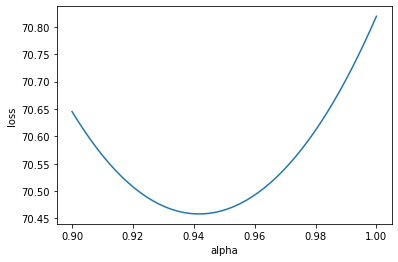

In [21]:
alpha_to_plot = []
y_to_plot = []
for time_index in range(34, 35):
    print("Time index {}".format(time_index))
    best_alpha, min_err = 0, 1e9
    for a in reversed(np.linspace(0.9, 1, 50)):
        start = time.time()
        tmp = 0
        for act in ['walking', 'eating', 'smoking', 'discussion']:
            err_3d = my_evaluate(test_data[act], model, train_dataset.dim_used, opt, alpha=a, j=24, dim=time_index)
            tmp += err_3d
        avg = tmp / len(['walking', 'eating', 'smoking', 'discussion'])
        if avg < min_err:
            min_err = avg
            best_alpha = a
        print('Time taken: {}'.format(time.time()-start))
        alpha_to_plot.append(a)
        y_to_plot.append(avg)
    print('Best alpha: {}'.format(best_alpha))
    print()

plt.plot(alpha_to_plot, y_to_plot)
plt.xlabel('alpha')
plt.ylabel('loss')
plt.show()

In [22]:
from torch.utils.data import Dataset
import numpy as np
from utils import data_utils
import torch
from utils.model import IdentityAutoencoder


class OldH36motion3D(Dataset):

    def __init__(self, path_to_data, actions, input_n=20, output_n=10, dct_used=15, split=0, sample_rate=2,
                 autoencoder=IdentityAutoencoder(), subset=False):
        """
        :param path_to_data:
        :param actions:
        :param input_n:
        :param output_n:
        :param dct_used:
        :param split: 0 train, 1 testing, 2 validation
        :param sample_rate:
        """
        self.path_to_data = path_to_data
        self.split = split
        self.dct_used = dct_used

        subs = np.array([[1, 6, 7, 8, 9], [5], [11]])
        acts = data_utils.define_actions(actions)

        if subset:
            subs = np.array([[1], [5], [11]])
            acts = ['walking']

        subjs = subs[split]
        all_seqs, dim_ignore, dim_used = data_utils.load_data_3d(path_to_data, subjs, acts, sample_rate,
                                                                 input_n + output_n)
        self.all_seqs = all_seqs
        self.dim_used = dim_used

        # (nb_total_seq, len_seq, nb_joints)
        all_seqs = torch.from_numpy(all_seqs[:, :, dim_used]).float()

        # (nb_total_seq, nb_joints, hidden_dim)
        self.all_seqs_encoded = autoencoder(all_seqs.transpose(2, 1))[1]
        tmp = all_seqs.transpose(2, 1).clone()

        # Pad with last seen skeleton
        tmp[:, :, input_n:] = tmp[:, :, input_n-1, None]
        self.all_seqs_encoded_padded = autoencoder(tmp)[1]

    def __len__(self):
        return self.all_seqs_encoded.shape[0]

    def __getitem__(self, item):
        return self.all_seqs_encoded_padded[item], self.all_seqs_encoded[item], \
               self.all_seqs[item], self.all_seqs_encoded_padded[item], self.all_seqs_encoded[item], \
               self.all_seqs[item]


In [23]:
# Load test dataset
acts = data_utils.define_actions('all')
test_data = dict()
for act in acts:
    test_dataset = OldH36motion3D(path_to_data=opt.data_dir, actions=act, input_n=input_n, output_n=output_n, split=1,
                               sample_rate=sample_rate, dct_used=dct_n)
    test_data[act] = DataLoader(
        dataset=test_dataset,
        batch_size=opt.test_batch,
        shuffle=False)

Reading subject 5, action walking, subaction 1
Reading subject 5, action walking, subaction 2
Reading subject 5, action eating, subaction 1
Reading subject 5, action eating, subaction 2
Reading subject 5, action smoking, subaction 1
Reading subject 5, action smoking, subaction 2
Reading subject 5, action discussion, subaction 1
Reading subject 5, action discussion, subaction 2
Reading subject 5, action directions, subaction 1
Reading subject 5, action directions, subaction 2
Reading subject 5, action greeting, subaction 1
Reading subject 5, action greeting, subaction 2
Reading subject 5, action phoning, subaction 1
Reading subject 5, action phoning, subaction 2
Reading subject 5, action posing, subaction 1
Reading subject 5, action posing, subaction 2
Reading subject 5, action purchases, subaction 1
Reading subject 5, action purchases, subaction 2
Reading subject 5, action sitting, subaction 1
Reading subject 5, action sitting, subaction 2
Reading subject 5, action sittingdown, subacti

Time index 34
Time taken: 0.5919864177703857
Time taken: 0.588144063949585
Time taken: 0.5913777351379395
Time taken: 0.5863442420959473
Time taken: 0.5871031284332275
Time taken: 0.6392636299133301
Time taken: 0.5825178623199463
Time taken: 0.7574038505554199
Time taken: 0.5871574878692627
Time taken: 0.5828597545623779
Time taken: 0.5810246467590332
Time taken: 0.5840468406677246
Time taken: 0.5933747291564941
Time taken: 0.5785315036773682
Time taken: 0.5655875205993652
Time taken: 0.5620183944702148
Time taken: 0.5801701545715332
Time taken: 0.5827889442443848
Time taken: 0.5846095085144043
Time taken: 0.5809183120727539
Time taken: 0.5966978073120117
Time taken: 0.5830128192901611
Time taken: 0.5800032615661621
Time taken: 0.5662937164306641
Time taken: 0.5638482570648193
Time taken: 0.595587968826294
Time taken: 0.563995361328125
Time taken: 0.5666172504425049
Time taken: 0.5825440883636475
Time taken: 0.5800139904022217
Time taken: 0.5687780380249023
Time taken: 0.57809686660766

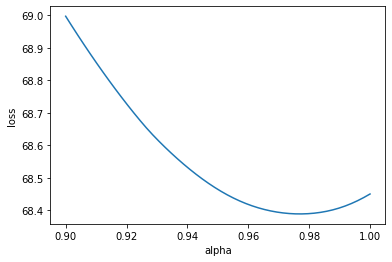

In [24]:
alpha_to_plot = []
y_to_plot = []
for time_index in range(34, 35):
    print("Time index {}".format(time_index))
    best_alpha, min_err = 0, 1e9
    for a in reversed(np.linspace(0.9, 1, 50)):
        start = time.time()
        tmp = 0
        for act in ['walking', 'eating', 'smoking', 'discussion']:
            err_3d = my_evaluate(test_data[act], model, train_dataset.dim_used, opt, alpha=a, j=24, dim=time_index)
            tmp += err_3d
        avg = tmp / len(['walking', 'eating', 'smoking', 'discussion'])
        if avg < min_err:
            min_err = avg
            best_alpha = a
        print('Time taken: {}'.format(time.time()-start))
        alpha_to_plot.append(a)
        y_to_plot.append(avg)
    print('Best alpha: {}'.format(best_alpha))
    print()

plt.plot(alpha_to_plot, y_to_plot)
plt.xlabel('alpha')
plt.ylabel('loss')
plt.show()